In [1]:
%run preprocess.ipynb
%run preprocessing_tweets.ipynb
import os 
import numpy as np
import json
import gensim
import nltk
import re
from nltk.corpus import stopwords
from copy import deepcopy
import pickle
from nltk.tokenize import TweetTokenizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# from preprocess import read_data
# from preprocess import get_features
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
all_data = read_data()

580323060533764097


In [63]:
model_name=['SVC_Linear','MLP','Logistic Regression','Decision Tree','Random Forest']

In [83]:
a=[[1,2]]

In [84]:
a[0][0]

1

In [143]:
from sklearn import preprocessing
from statistics import mean 
le = preprocessing.LabelEncoder()

In [201]:
Wrong_conf_with={}
right_conf_with={}
Wrong_conf_without={}
right_conf_without={}
accuracy_with={}
accuracy_without={}
f_score_with={}
f_score_without={}

#### Calculating analysis of model and its confidence score

In [202]:
def with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test,count,title,name):
    cv = CountVectorizer()
    cv_fit=cv.fit_transform(BOW_sents)
    BOW_features = cv_fit.toarray()
    
    # Append features with Bag of words
    X = []
    for i in range(len(BOW_features)):
        line = list(BOW_features[i]) + all_extra_feats[i]
        X.append(line)
        
    model.fit(X, Y)

    # preprocess testing set
    test_cv_fit = cv.transform(test_BOW_sents)
    test_BOW_features = test_cv_fit.toarray()

    # Append features
    X_test = []
    for i in range(len(test_BOW_features)):
        line = list(test_BOW_features[i]) + test_all_extra_feats[i]
        X_test.append(line)
        
    Y_pred = model.predict(X_test)
#     if count==1:
#         print("Confidence: ",class_probabilities = model.predict_proba(sub_main))
    print("Analysis for model "+name)
    confidence=[]
    if count ==1 or count==3:
        confidence=model.decision_function(X_test)
        confidence=confidence.tolist()
        print(type(confidence))
        print("Confidence score: ",confidence)
    else:
        confidence=model.predict_proba(X_test)
        confidence=confidence.tolist()
        print(type(confidence))
        print("Confidence score: ",confidence)
        
    print("accuracy : ", accuracy_score(Y_test, Y_pred))
    accuracy_with[name]=accuracy_score(Y_test, Y_pred)
    print("Macro F: ", f1_score(Y_test, Y_pred, average='macro'))
    wrong=[]
    right=[]
    le.fit(Y_test)
    Y_test1=le.transform(Y_test)
    Y_pred1=le.transform(Y_pred)
    for i in range(len(Y_test)):
        x=map(abs,confidence[i])
        print("xxx ",x)
        if Y_test1[i] == Y_pred1[i]:
            right.append(max(x))
        else:
            wrong.append(max(x))
            
            
    print("right ",len(right))
    print("left ",len(wrong))
    Wrong_conf_with[name]=mean(wrong)
    right_conf_with[name]=mean(right)
    f_score_with[name]= f1_score(Y_test, Y_pred, average='macro')
    print("Confidence_wrong ",mean(wrong))
    print("Confidence_right ",mean(right))
            
    cf_matrix = confusion_matrix(Y_test, Y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in range(3)],columns = [i for i in range(3)])
    plt.figure(figsize = (6,4))
#     sn.heatmap(df_cm, annot=True)
    svm = sn.heatmap(df_cm, annot=True)
    fig = svm.get_figure()
    fig.savefig(title)
    return Y_pred

In [203]:
def without_tweet_context(X, Y, model, X_test, Y_test,count,title,name):
    model.fit(X, Y)
    Y_pred = model.predict(X_test)
#     if count==1:
    confidence=[]
    print("Analysis for model "+name)
    if count ==1 or count==3:
        confidence=model.decision_function(X_test)
        confidence=confidence.tolist()
        print(type(confidence))
        print("Confidence score: ",confidence)
    else:
        confidence=model.predict_proba(X_test)
        confidence=confidence.tolist()
        print(type(confidence))
        print("Confidence score: ",confidence)
    accuracy_without[name]=accuracy_score(Y_test, Y_pred)
    print("accuracy : ", accuracy_score(Y_test, Y_pred))
    print("Macro F: ", f1_score(Y_test, Y_pred, average='macro'))
    f_score_without[name]= f1_score(Y_test, Y_pred, average='macro')
    wrong=[]
    right=[]
    
    le.fit(Y_test)
    Y_test1=le.transform(Y_test)
    Y_pred1=le.transform(Y_pred)
    for i in range(len(Y_test)):
#         print(Y_test1[i])
        x=map(abs,confidence[i])
        print("xxx ",x)
        if Y_test1[i] == Y_pred1[i]:
            right.append(max(x))
        else:
            wrong.append(max(x))
            
            
    print("right ",len(right))
    print("left ",len(wrong))
    Wrong_conf_without[name]=mean(wrong)
    right_conf_without[name]=mean(right)
    print("Confidence_wrong ",mean(wrong))
    print("Confidence_right ",mean(right))
    cf_matrix = confusion_matrix(Y_test, Y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in range(3)],columns = [i for i in range(3)])
    plt.figure(figsize = (6,4))
#     sn.heatmap(df_cm, annot=True)   
    svm = sn.heatmap(df_cm, annot=True)
    fig = svm.get_figure()
    fig.savefig(title)
    return Y_pred

In [204]:
def write_to_json(ids, pred, path):
    submission = {}
    for i, id in enumerate(ids):
        submission[id] = [pred[i], 1]
        subtaskaenglish = {}
        subtaskbenglish = {}
        
    answer = {}
    answer['subtaskaenglish'] = {}
    answer['subtaskbenglish'] = submission

    answer['subtaskadanish'] = {}
    answer['subtaskbdanish'] = {}

    answer['subtaskarussian'] = {}
    answer['subtaskbrussian'] = {}
        
    with open(path, 'w') as f:
        json.dump(answer, f)

In [205]:
from sklearn.calibration import CalibratedClassifierCV

<class 'sklearn.svm.classes.LinearSVC'>
Without the context of the tweet in context
Analysis for model SVC_Linear
<class 'list'>
Confidence score:  [[-0.5291490657975637, -0.2531103795329817, -0.2142899417412938], [-0.20550825029940337, -0.24577333551645877, -0.5390365698135731], [-0.3892312491175851, -0.18962830964036698, -0.4162818953865538], [-0.1477212432640161, -0.25605496312160925, -0.5833528579089733], [-0.21115060276310485, -0.3839033227381016, -0.40205050585297597], [-0.34713511478377745, -0.1623593997267603, -0.48324625874071675], [-0.6372444370005842, 0.1789141132952674, -0.5497746975127885], [-0.36227304484414247, -0.1403555869268785, -0.49090449076276277], [-0.3092902896328649, -0.21736893172646485, -0.46410067868560173], [0.14907305464260892, -0.6325391572209309, -0.5091146784030754], [0.06479782101784187, -0.5387420259660356, -0.5173097671457482], [-0.4389018271220849, -0.38840045851715144, -0.17009565574001184], [-0.4044991809872083, -0.3704006894844488, -0.231439042352


With the context of the tweet in context
Analysis for model SVC_Linear
<class 'list'>
Confidence score:  [[-0.42533637420560433, -0.145582640488018, -0.4297262925351441], [-0.4121156058769829, -0.13440368069189668, -0.2626447182516835], [-0.11386317473156284, -0.22195918498706024, -0.6590933892726841], [-0.29984034073776644, -0.1970299998115858, -0.4567757184696102], [-0.17601616716148294, -0.39783560764182174, -0.32359121655571177], [-0.5817748729102558, 0.16208785378631219, -0.47089122612387774], [-0.8457241860159586, 0.4898868292724723, -0.5544523568902687], [-0.7699016880917181, 0.3738263116288475, -0.5201802428703488], [-0.09233226750081613, -0.5367463671244729, -0.3246860545734672], [0.01863462207336282, -0.46093567240572275, -0.4611632625446054], [-0.01310022296649968, -0.41715026763868723, -0.46625089133291175], [-0.12598272241819203, -0.290645187381108, -0.5127646794295537], [-0.10549979198757999, -0.276359215714743, -0.6340884398019146], [-0.04113054910592075, -0.38593351294

--------
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Without the context of the tweet in context


/home/dhawal/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Analysis for model MLP
<class 'list'>
Confidence score:  [[0.04703284530364846, 0.4323068369316968, 0.5206603177646547], [0.3536899357614825, 0.5148395309351812, 0.13147053330333625], [0.19315898041041354, 0.5659656970905554, 0.24087532249903115], [0.34792230584510125, 0.5735103327046871, 0.07856736145021154], [0.962972764887613, 0.0017494219414267455, 0.035277813170960244], [0.06736235120644352, 0.791017339820507, 0.14162030897304942], [0.11213525360195102, 0.6327638626345483, 0.25510088376350054], [0.0865444945352148, 0.7639580847822836, 0.1494974206825017], [0.03620573722943565, 0.8617431009988298, 0.10205116177173443], [0.9935580196141348, 0.005934524893495756, 0.0005074554923694078], [0.9046482873878584, 0.0869546413338154, 0.008397071278326203], [0.7035836458593063, 0.16383164583094373, 0.1325847083097499], [0.09924362348890547, 0.4978513793125839, 0.40290499719851064], [0.034575410686587836, 0.915133450464365, 0.050291138849047096], [0.039272524306685826, 0.8473251219454221, 0.1

With the context of the tweet in context
Analysis for model MLP
<class 'list'>
Confidence score:  [[0.11919903667431841, 0.5478505411198895, 0.332950422205792], [0.08291087340475843, 0.3604655547896105, 0.556623571805631], [0.15789945591123278, 0.6881283787397714, 0.15397216534899588], [0.3396833575836264, 0.5088599901786752, 0.15145665223769833], [0.29465053768497257, 0.31774903242396585, 0.3876004298910615], [0.07862790547950117, 0.681829973377229, 0.23954212114326998], [0.023159507879248344, 0.8742964279485078, 0.10254406417224375], [0.019992210646615945, 0.8924372710015903, 0.08757051835179373], [0.374420099596231, 0.04993111397482286, 0.5756487864289461], [0.2190665083568173, 0.5564009347239501, 0.22453255691923266], [0.2054323085567133, 0.5829663780478693, 0.2116013133954174], [0.11492858483379974, 0.6654827062047605, 0.21958870896143978], [0.33796248077378754, 0.34825069793323155, 0.3137868212929809], [0.5368188793695075, 0.20762537929039854, 0.25555574134009396], [0.47406009413

--------
<class 'sklearn.linear_model.logistic.LogisticRegression'>
Without the context of the tweet in context
Analysis for model Logistic Regression
<class 'list'>
Confidence score:  [[-0.31203445309641403, 0.13801503332167375, 0.17401941977475266], [0.22654078362542937, 0.12803514531567567, -0.354575928941097], [-0.08659918427984353, 0.2376152065610932, -0.15101602228124322], [0.2720453926683655, 0.12989078640849994, -0.40193617907685736], [0.11683985873887981, 0.02770008778405617, -0.14453994652292923], [-0.06674337432805344, 0.28602302830832693, -0.219279653980267], [-0.4059657735090339, 0.6688407962027393, -0.26287502269369867], [-0.08604877482790524, 0.31167916855046285, -0.2256303937225511], [-0.01847987307842386, 0.22188267770298717, -0.20340280462455682], [0.47242036071686083, -0.20470809897858736, -0.2677122617382661], [0.37539845639739666, -0.10300637804742611, -0.2723920783499633], [-0.3538916465950969, 0.06746495191562105, 0.2864266946794869], [-0.17602310676133098, 0.019


With the context of the tweet in context
Analysis for model Logistic Regression
<class 'list'>
Confidence score:  [[-0.14516825660079485, 0.38117016550439087, -0.23600190890359835], [-0.08935154834886189, 0.06411456450626726, 0.025236983842590988], [0.34467723414723345, 0.025916569084575597, -0.37059380323181124], [0.24273181739830835, 0.07643830688891023, -0.3191701242872226], [0.3046765549980365, -0.29237909440457965, -0.012297460593459708], [-0.30399217867026246, 0.5286221394631752, -0.2246299607929153], [-0.6742999566482917, 1.0125428834481558, -0.33824292679986667], [-0.5107815912083058, 0.7435281911024257, -0.23274659989412227], [0.3847208652683892, -0.3609090796180482, -0.02381178565034378], [0.4865246199163691, -0.24979733792309597, -0.23672728199327592], [0.4396952663412956, -0.20093222786358242, -0.23876303847771602], [0.15713602300313345, 0.021140882380675186, -0.17827690538381102], [0.4108529375703246, 0.057731920696265815, -0.4685848582665938], [0.505133831066177, -0.3017

--------
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Without the context of the tweet in context
Analysis for model Decision Tree
<class 'list'>
Confidence score:  [[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.5, 0.25, 0.25], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.5, 0.25, 0.25], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.5, 0.25, 0.25], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 

Confidence_wrong  1.0
Confidence_right  1.0
--------
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Without the context of the tweet in context
Analysis for model Random Forest
<class 'list'>
Confidence score:  [[0.1, 0.6, 0.3], [0.0, 0.9, 0.1], [0.2, 0.7, 0.1], [0.4, 0.36, 0.24], [0.5, 0.1, 0.4], [0.13999999999999999, 0.86, 0.0], [0.0, 0.6, 0.4], [0.0, 0.8666666666666666, 0.13333333333333333], [0.1, 0.6, 0.3], [0.6, 0.2, 0.2], [0.6, 0.1, 0.3], [0.3, 0.3, 0.4], [0.1, 0.4333333333333333, 0.4666666666666666], [0.2, 0.6, 0.2], [0.3, 0.3, 0.4], [0.1, 0.4, 0.5], [0.1, 0.8, 0.1], [0.2, 0.1, 0.7], [0.7, 0.2, 0.1], [0.5054978354978353, 0.28008658008658005, 0.21441558441558445], [0.7, 0.1, 0.2], [0.4, 0.1, 0.5], [0.1, 0.9, 0.0], [0.0, 1.0, 0.0], [0.1, 0.4, 0.5], [0.6, 0.4, 0.0], [0.06666666666666667, 0.5733333333333334, 0.36], [0.2, 0.8, 0.0], [0.8, 0.1, 0.1], [0.3, 0.2, 0.5], [0.3, 0.2, 0.5], [0.41, 0.38, 0.21000000000000002], [0.3, 0.6, 0.1], [0.05, 0.25, 0.7], [0.2, 0.3, 0.5], [0.5

/home/dhawal/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Analysis for model Random Forest
<class 'list'>
Confidence score:  [[0.2, 0.6, 0.2], [0.3, 0.6, 0.1], [0.4, 0.5, 0.1], [0.6, 0.3, 0.1], [0.7, 0.3, 0.0], [0.5, 0.5, 0.0], [0.3, 0.7, 0.0], [0.5, 0.5, 0.0], [0.4, 0.5, 0.1], [0.5, 0.3, 0.2], [0.5, 0.3, 0.2], [0.3, 0.2, 0.5], [0.3, 0.4, 0.3], [0.3, 0.6, 0.1], [0.4, 0.5, 0.1], [0.5, 0.4, 0.1], [0.5, 0.3, 0.2], [0.6, 0.4, 0.0], [0.8, 0.2, 0.0], [0.5, 0.5, 0.0], [0.5, 0.3, 0.2], [0.4, 0.5, 0.1], [0.4, 0.5, 0.1], [0.2, 0.7, 0.1], [0.2, 0.7, 0.1], [0.5, 0.4, 0.1], [0.2, 0.7, 0.1], [0.4, 0.4, 0.2], [0.7, 0.2, 0.1], [0.4, 0.5, 0.1], [0.5, 0.4, 0.1], [0.3, 0.7, 0.0], [0.4, 0.6, 0.0], [0.2, 0.6, 0.2], [0.4, 0.4, 0.2], [0.7, 0.3, 0.0], [0.3, 0.5, 0.2], [0.3, 0.5, 0.2], [0.2, 0.7, 0.1], [0.4, 0.4, 0.2], [0.4, 0.4, 0.2], [0.2, 0.6, 0.2], [0.4, 0.4, 0.2], [0.3, 0.4, 0.3], [0.3, 0.6, 0.1], [0.3, 0.4, 0.3], [0.4, 0.2, 0.4], [0.1, 0.9, 0.0], [0.4, 0.2, 0.4], [0.6, 0.2, 0.2], [0.3, 0.6, 0.1], [0.4, 0.5, 0.1], [0.5, 0.3, 0.2], [0.5, 0.4, 0.1], [0.3, 0.6, 0.1

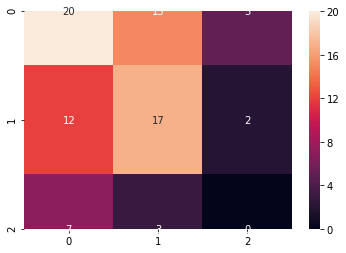

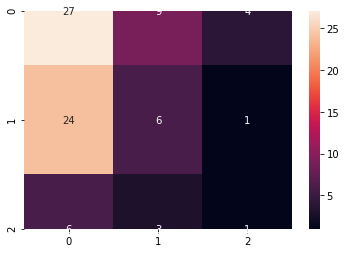

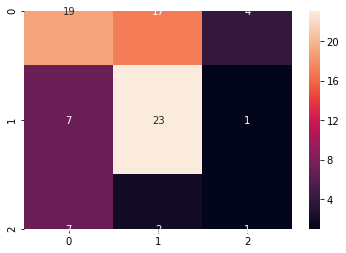

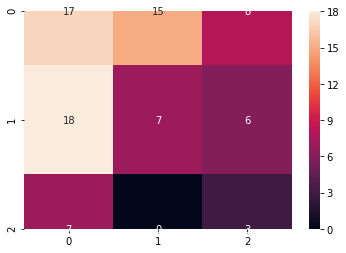

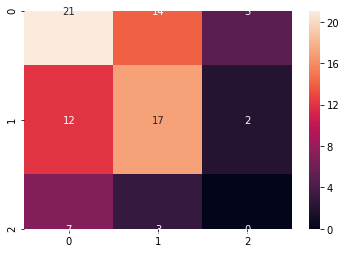

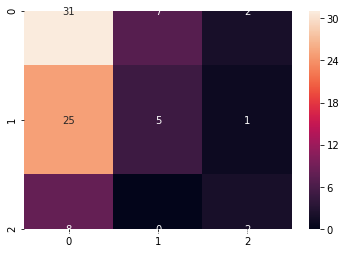

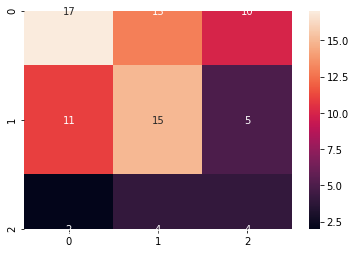

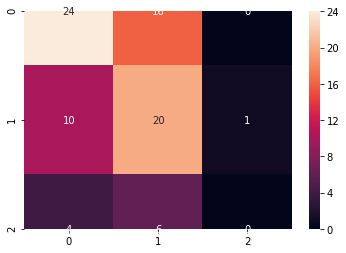

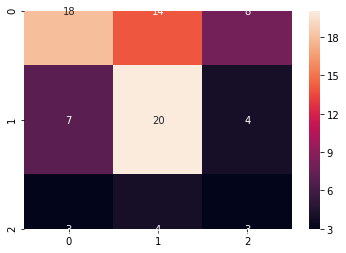

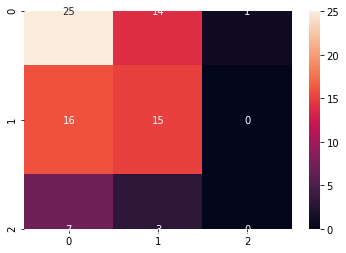

In [206]:
# def main(all_data):
    # Get Bag Of Words
BOW_sents, all_extra_feats, Y, ids = get_features(all_data, whichset="training+development")

test_BOW_sents, test_all_extra_feats, Y_test, ids_test = get_features(all_data, whichset="testing")

with open('rumoureval2019_data/final-eval-key.json') as fil:
    test = json.load(fil)
for ids in ids_test:
    Y_test.append(test['subtaskbenglish'][ids])

models = []
# models.append(CalibratedClassifierCV(LinearSVC(random_state=364)))
models.append(LinearSVC(random_state=364))
models.append(MLPClassifier(hidden_layer_sizes=(100,50),max_iter=1000))
models.append(LogisticRegression(multi_class='multinomial',solver='lbfgs'))
models.append(tree.DecisionTreeClassifier())
models.append(RandomForestClassifier())


count = 1
for model in models:
    print(type(model))
    print("Without the context of the tweet in context")
    Y_pred = without_tweet_context(all_extra_feats, Y, model, test_all_extra_feats, Y_test,count,"model_without_"+str(count)+".png",model_name[count-1])
    path = "answer_without_"+str(count)+".json"
    write_to_json(ids_test, Y_pred, path)
    print()
    print("With the context of the tweet in context")
    Y_pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test,count,"model_with_"+str(count)+".png",model_name[count-1])
    path = "answer_without_"+str(count)+".json"
    write_to_json(ids_test, Y_pred, path)
    print("--------")
    count += 1


In [208]:
# Y_pred = without_tweet_context(all_extra_feats, Y, models[0], test_all_extra_feats, Y_test, 'model0_without')

In [ ]:
# Y_pred = without_tweet_context(all_extra_feats, Y, model[4], test_all_extra_feats, Y_test)

In [ ]:
# !pip install seaborn

In [ ]:
X_axis = []
for model in models:
#     print(type(model))
#     print("Without the context of the tweet in context")
    pred = without_tweet_context(all_extra_feats, Y, model, test_all_extra_feats, Y_test)
    X_axis.append(accuracy_score(Y_test, pred))
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print()
#     print("With the context of the tweet in context")
#     Y_pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test)
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print("--------")

#     count += 1

In [ ]:
X_axis

In [ ]:
X_axis = []
for model in models:
#     print(type(model))
#     print("Without the context of the tweet in context")
    pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test)
    X_axis.append(accuracy_score(Y_test, pred))
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print()
#     print("With the context of the tweet in context")
#     Y_pred = with_tweet_context(BOW_sents, all_extra_feats, Y, model, test_BOW_sents, test_all_extra_feats, Y_test)
#     path = "answer_without_"+str(count)+".json"
#     write_to_json(ids_test, Y_pred, path)
#     print("--------")
#     count += 1

Without BOW Accuracy+ F1 score vs models


/home/dhawal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support dict_values([0.4567901234567901, 0.5308641975308642, 0.4691358024691358, 0.4444444444444444, 0.5061728395061729]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/home/dhawal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support dict_values([0.3404935430251886, 0.42522831050228316, 0.3493589743589744, 0.4125889436234263, 0.44970730321113955]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()


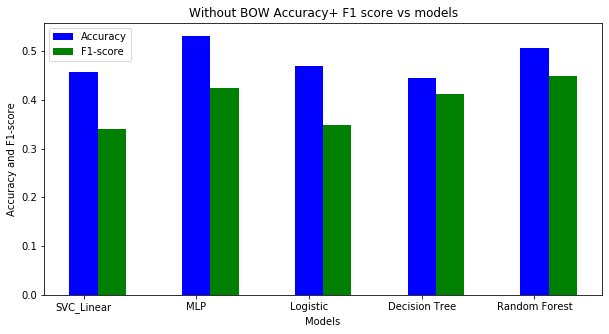

In [232]:
X = np.arange(5)
f, ax = plt.subplots(figsize=(10,5))
ax.set_xticklabels(['z','SVC_Linear','MLP','Logistic','Decision Tree','Random Forest'])
# ax.set_yticks(accuracy_without.values(), f_score_without.values())
print("Without BOW Accuracy+ F1 score vs models")
plt.title('Without BOW Accuracy+ F1 score vs models')
plt.xlabel('Models')
plt.ylabel('Accuracy and F1-score')
plt.bar(X + 0.00, accuracy_without.values(), color = 'b',label="Accuracy", width = 0.25)
plt.bar(X + 0.25, f_score_without.values(), color = 'g',label="F1-score" ,width = 0.25)
ax.legend((accuracy_without.values(), f_score_without.values()), ('Men', 'Women'))
plt.legend()

With BOW Accuracy+ F1 score vs models


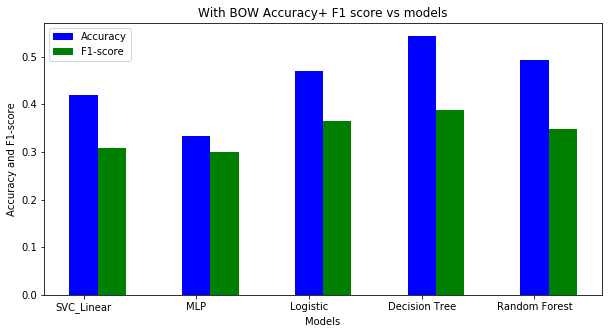

In [233]:
X = np.arange(5)
f, ax = plt.subplots(figsize=(10,5))
ax.set_xticklabels(['z','SVC_Linear','MLP','Logistic','Decision Tree','Random Forest'])
print("With BOW Accuracy+ F1 score vs models")
plt.title('With BOW Accuracy+ F1 score vs models')
plt.xlabel('Models')
plt.ylabel('Accuracy and F1-score')
plt.bar(X + 0.00, accuracy_with.values(), color = 'b',label="Accuracy", width = 0.25)
plt.bar(X + 0.25, f_score_with.values(), color = 'g',label="F1-score" ,width = 0.25)
plt.legend()

In [213]:
X = np.arange(5)

With case Accuracy+ F1 score vs models


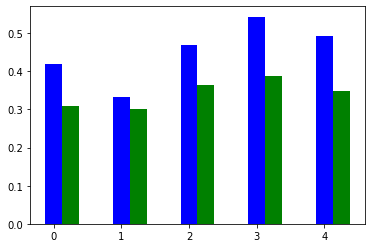

In [219]:
print("With case Accuracy+ F1 score vs models")
plt.bar(X + 0.00, accuracy_with.values(), color = 'b', width = 0.25)
plt.bar(X + 0.25, f_score_with.values(), color = 'g', width = 0.25)
plt.show()

without tweet context
[0.41975308641975306, 0.3333333333333333, 0.4691358024691358, 0.5432098765432098, 0.5185185185185185]


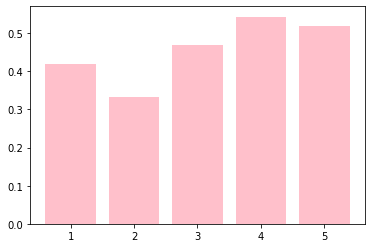

Graph Plotting the variation of accuracy for different models 


In [38]:
print("without tweet context")
print(X_axis)
plt.bar([1,2,3,4,5], X_axis, color = 'pink')
plt.show()
print("Graph Plotting the variation of accuracy for different models ")

Wrong_Confidence_With


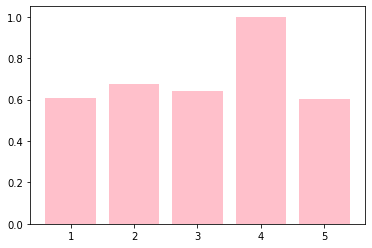

Graph Plotting the variation of wrong confidence for different models 


In [193]:
print("Wrong_Confidence_With")
# print()
plt.bar([1,2,3,4,5], Wrong_conf_with.values(), color = 'pink')
plt.show()
print("Graph Plotting the variation of wrong confidence for different models ")

Wrong_Confidence_Without


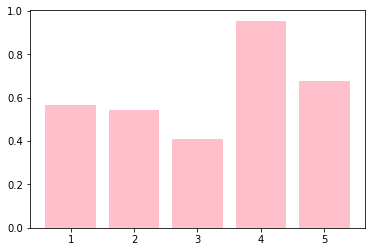

Graph Plotting the variation of wrong confidence for different models 


In [194]:
print("Wrong_Confidence_Without")
# print()
plt.bar([1,2,3,4,5], Wrong_conf_without.values(), color = 'pink')
plt.show()
print("Graph Plotting the variation of wrong confidence for different models ")

right_Confidence_With


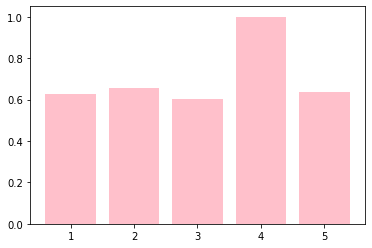

Graph Plotting the variation of wrong confidence for different models 


In [195]:
print("right_Confidence_With")
# print()
plt.bar([1,2,3,4,5], right_conf_with.values(), color = 'pink')
plt.show()
print("Graph Plotting the variation of wrong confidence for different models ")

right_Confidence_With


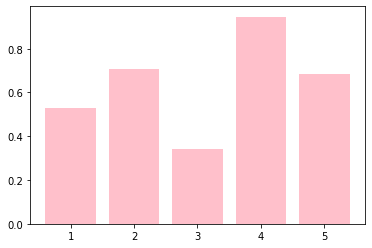

Graph Plotting the variation of wrong confidence for different models 


In [196]:
print("right_Confidence_With")
# print()
plt.bar([1,2,3,4,5], right_conf_without.values(), color = 'pink')
plt.show()
print("Graph Plotting the variation of wrong confidence for different models ")

In [192]:
print("Accuracy: ",accuracy_with)
print("Wrong confidence: ",Wrong_conf_with)
print("Right Confidence: ",right_conf_with)

Accuracy:  {'SVC_Linear': 0.41975308641975306, 'MLP': 0.3333333333333333, 'Logistic Regression': 0.4691358024691358, 'Decision Tree': 0.5308641975308642, 'Random Forest': 0.5308641975308642}
Wrong confidence:  {'SVC_Linear': 0.6063819910422032, 'MLP': 0.673034088958004, 'Logistic Regression': 0.6404863134359076, 'Decision Tree': 1.0, 'Random Forest': 0.6026315789473684}
Right Confidence:  {'SVC_Linear': 0.6280394248977949, 'MLP': 0.6578729538469545, 'Logistic Regression': 0.6037163327946462, 'Decision Tree': 1.0, 'Random Forest': 0.6348837209302326}


In [191]:
print("Accuracy: ",accuracy_without)
print("Wrong Confidence ",Wrong_conf_without)
print("Right Confidence ",right_conf_without)

Accuracy:  {'SVC_Linear': 0.4567901234567901, 'MLP': 0.48148148148148145, 'Logistic Regression': 0.4691358024691358, 'Decision Tree': 0.4567901234567901, 'Random Forest': 0.5432098765432098}
Wrong Confidence  {'SVC_Linear': 0.5655764935546699, 'MLP': 0.5418116004809157, 'Logistic Regression': 0.41003458183130953, 'Decision Tree': 0.9545454545454546, 'Random Forest': 0.6759009009009009}
Right Confidence  {'SVC_Linear': 0.5294264983062849, 'MLP': 0.7083321526797802, 'Logistic Regression': 0.3405128733018492, 'Decision Tree': 0.9459459459459459, 'Random Forest': 0.6862121212121212}
